<a href="https://colab.research.google.com/github/HibanaSledge/First-Project/blob/master/CSC3160_2024_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3

The goal of assignment 3 is for your learn TD-IDF, cosine similarity, and embedding.

Here are four types of data (i.e. four categories of lyrics)
* https://slpcourse.github.io/materials/lyrics/country.txt
* https://slpcourse.github.io/materials/lyrics/pop.txt
* https://slpcourse.github.io/materials/lyrics/rap.txt
* https://slpcourse.github.io/materials/lyrics/rock.txt

Each song is segmented by `<SONG_BOUNDARY>`

## Task 1: TF-IDF [60 marks]

Implement the TF-IDF algorithm. You need to write your own compute_tf, and compute_idf functions.

In [5]:
import requests
import math
from collections import defaultdict

# 计算TF (Term Frequency)
def compute_tf(text):
    words = text.split()
    tf_dict = defaultdict(int)
    for word in words:
        tf_dict[word] += 1
    tf_dict = {word: count / len(words) for word, count in tf_dict.items()}
    return tf_dict

# 计算IDF (Inverse Document Frequency)
def compute_idf(documents):
    N = len(documents)
    idf_dict = {}
    all_words = set(word for document in documents for word in document.split())
    for word in all_words:
        containing_docs = sum(1 for document in documents if word in document)
        idf_dict[word] = math.log(N / containing_docs) + 1
    return idf_dict

# 计算TF-IDF
def compute_tf_idf(tf, idf):
    tf_idf = {word: tf[word] * idf.get(word, 0) for word in tf}
    return tf_idf

# 下载歌词并分割成单独的歌曲
def download_and_split_lyrics(url):
    response = requests.get(url)
    lyrics = response.text
    songs = lyrics.split('<SONG_BOUNDARY>')
    # 移除空字符串
    songs = [song.strip() for song in songs if song.strip()]
    return songs

# 主函数
def main(urls):
    all_songs = []
    for url in urls:
        songs = download_and_split_lyrics(url)
        all_songs.extend(songs)

    # 计算全局IDF
    global_idf = compute_idf(all_songs)

    for url in urls:
        songs = download_and_split_lyrics(url)
        word_tf_idf_scores = defaultdict(list)
        for song in songs:
            tf = compute_tf(song)
            tf_idf = compute_tf_idf(tf, global_idf)
            for word, score in tf_idf.items():
                word_tf_idf_scores[word].append(score)

        # 计算每个词的平均TF-IDF分数并排序
        avg_scores = {word: sum(scores) / len(scores) for word, scores in word_tf_idf_scores.items()}
        sorted_scores = sorted(avg_scores.items(), key=lambda x: x[1], reverse=True)[:5]

        # 输出得分最高的前5个词
        print(f"\nTop 5 TF-IDF scores for words in {url}:")
        for word, score in sorted_scores:
            print(f"{word}: {score}")

urls = [
    "https://slpcourse.github.io/materials/lyrics/country.txt",
    "https://slpcourse.github.io/materials/lyrics/pop.txt",
    "https://slpcourse.github.io/materials/lyrics/rap.txt",
    "https://slpcourse.github.io/materials/lyrics/rock.txt"
]

if __name__ == "__main__":
    main(urls)



Top 5 TF-IDF scores for words in https://slpcourse.github.io/materials/lyrics/country.txt:
Death: 0.7117894423410955
Row: 0.7117894423410955
halos: 0.5140047215578708
superhero: 0.44832634046992065
unapologetically: 0.42737651147599914

Top 5 TF-IDF scores for words in https://slpcourse.github.io/materials/lyrics/pop.txt:
sono: 0.7655094002536311
Pharrell: 0.7336249207689611
waves,: 0.730856524841531
Timberland: 0.6337510763445875
Onosim: 0.6090471040346092

Top 5 TF-IDF scores for words in https://slpcourse.github.io/materials/lyrics/rap.txt:
jiggy,: 0.6298438344162788
say?: 0.5779592260004625
Thursday,: 0.5748098920440489
baker's: 0.5659392245931986
Katrina,: 0.5071639932857513

Top 5 TF-IDF scores for words in https://slpcourse.github.io/materials/lyrics/rock.txt:
meeny: 0.9739503258484484
cartoon: 0.791065173309556
Closer: 0.7660447215125498
T-t-touching: 0.7565506995429911
Channel: 0.7420573911226274


## Task 2: Kmeans clustering [40 marks]

Perform kmeans clustering with the TF-IDF weights. You need to initialize the kmeans centroid in two different ways: random initialization, and smart initialization where you initialize the centroid with a vector from each category.

Here are your tasks

*   Visualize the clustering results from random initialization. each cluster need to have its own color, and highlight the centroid
*   Visualize the clustering results from smart initialization. each cluster need to have its own color, and highlight the centroid
*   Calculate the cosine similarity of the kmeans centroid from smart initialization. Present your result in a table
*   Discuss the difference and your observation

You may use scikit-learn for kmeans clustering and t-SNE visualization



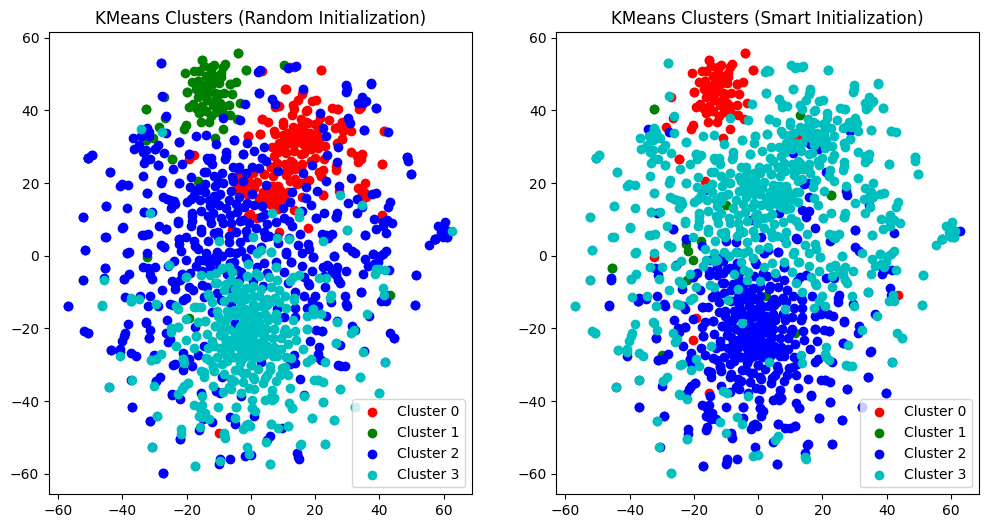

Cosine Similarity Matrix (Smart Initialization):
[[1.         0.51807424 0.59076295 0.67114897]
 [0.51807424 1.         0.59753076 0.68606262]
 [0.59076295 0.59753076 1.         0.82390829]
 [0.67114897 0.68606262 0.82390829 1.        ]]


In [6]:
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine

# 下载歌词并分割成单独的歌曲
def download_and_split_lyrics(url):
    response = requests.get(url)
    lyrics = response.text
    songs = lyrics.split('<SONG_BOUNDARY>')
    # 移除空字符串
    songs = [song.strip() for song in songs if song.strip()]
    return songs

# URL列表
urls = [
    "https://slpcourse.github.io/materials/lyrics/country.txt",
    "https://slpcourse.github.io/materials/lyrics/pop.txt",
    "https://slpcourse.github.io/materials/lyrics/rap.txt",
    "https://slpcourse.github.io/materials/lyrics/rock.txt"
]

# 下载并处理所有歌词
all_songs = []
for url in urls:
    all_songs.extend(download_and_split_lyrics(url))

# 计算TF-IDF权重
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(all_songs)

# 执行KMeans聚类 - 随机初始化
num_clusters = 4  # 假设我们有4个类别
kmeans_random = KMeans(n_clusters=num_clusters, init='random', n_init=10, max_iter=300, random_state=42)
kmeans_random.fit(tfidf_matrix)

# 智能初始化（这里简单地选择前四个文档作为初始中心）
initial_centroids = tfidf_matrix[:num_clusters].toarray()
kmeans_smart = KMeans(n_clusters=num_clusters, init=initial_centroids, n_init=1)
kmeans_smart.fit(tfidf_matrix)

# 使用t-SNE进行可视化
tsne = TSNE(n_components=2, random_state=42)
tfidf_matrix_reduced = tsne.fit_transform(tfidf_matrix.toarray())

# 随机初始化的聚类可视化
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('KMeans Clusters (Random Initialization)')
colors = ['r', 'g', 'b', 'c']
for i in range(num_clusters):
    points = tfidf_matrix_reduced[kmeans_random.labels_ == i]
    plt.scatter(points[:, 0], points[:, 1], c=colors[i], label=f'Cluster {i}')
plt.legend()

# 智能初始化的聚类可视化
plt.subplot(1, 2, 2)
plt.title('KMeans Clusters (Smart Initialization)')
for i in range(num_clusters):
    points = tfidf_matrix_reduced[kmeans_smart.labels_ == i]
    plt.scatter(points[:, 0], points[:, 1], c=colors[i], label=f'Cluster {i}')
plt.legend()
plt.show()

# 计算余弦相似性（智能初始化的质心）
cos_sim_matrix = np.zeros((num_clusters, num_clusters))
for i in range(num_clusters):
    for j in range(num_clusters):
        cos_sim_matrix[i, j] = 1 - cosine(kmeans_smart.cluster_centers_[i], kmeans_smart.cluster_centers_[j])

# 展示余弦相似性矩阵
print("Cosine Similarity Matrix (Smart Initialization):")
print(cos_sim_matrix)
